In [1]:
import re
import numpy as np
import random
import time
from datetime import datetime, timedelta
import math
from IPython.display import Image


#Dataframes + read data
import pickle
import json 
import geojson
import geocoder

import pandas as pd      #Package for handling large data structures
import geopandas as gpd  #http://localhost:8888/notebooks/KTH/GitHub/DF23_cycle/M_stat_all.ipynb#Package for handling geospatial data
from geopandas import GeoDataFrame, read_file
from pyproj import CRS   #coordinate reference system

#Shapes
from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString, shape
from shapely import wkt  #If the geo_data is in wkt-format, this package is needed to "read" that (wtk - well known text)
import shapely as shp
from shapely.geometry import box

#Plotting
import hvplot.pandas 
import matplotlib.pyplot as plt
from holoviews import opts, dim
import warnings
warnings.filterwarnings('ignore')

plot_defaults = {'linewidth':5, 'capstyle':'round', 'figsize':(9,3), 'legend':True}
opts.defaults(opts.Overlay(active_tools=['wheel_zoom']))
hvplot_defaults = {'tiles':'CartoLight', 'frame_height':320, 'frame_width':320, 'cmap':'Viridis', 'colorbar':True}

import matplotlib.colors as mplcolors
from matplotlib.cm import ScalarMappable
import seaborn as sns

#Gurobi
import gurobipy as gp
from gurobipy import GRB

## Test

There are three simple tests to check if the code is working properly.

1. The nodes have a simple crux structure.
2. The nodes have a crux structure with the addition of a left-down node to see its effect.
3. Very very simple structure with three nodes in line to control whether the flow management (so the constraints) are right.

In [2]:
with open('Data/test4') as f:
    test = f.read().splitlines()
n_nodes = int(test[0])
points = ["point" + str(i) for i in range(n_nodes)]
test = test[1::]
coords = []
for i in range(n_nodes):
    coords.append(Point(test[i].split(" ")))
test = test[n_nodes::]
df = pd.DataFrame(columns=points, index=points)
for i in range(n_nodes):
    df.iloc[i] = [float(x) for x in test[i].split(" ")]
df["geometry"] = coords
    
# get distance matrix from point coordinates
gdf = gpd.GeoDataFrame(df, geometry='geometry')
for p in range(n_nodes):
    for q in range(n_nodes):
        gdf.iloc[p,q] = coords[p].distance(coords[q])
gdf["total_outflow"] = df.iloc[:,:-1].sum(axis=0)
gdf["total_inflow"] = df.iloc[:,:-1].sum(axis=1)

In [3]:
df

,point0,point1,point2,point3,geometry
point0,0.0,0.0,0.0,5.0,POINT (-1 1)
point1,0.0,0.0,0.0,6.0,POINT (-1 -1)
point2,0.0,0.0,0.0,0.0,POINT (0 0)
point3,5.0,6.0,0.0,0.0,POINT (1 0)


        Note that the demand D_ij must be considered with i-column and j-row.

In [4]:
gdf

,point0,point1,point2,point3,geometry,total_outflow,total_inflow
point0,0.0,2.0,1.414214,2.236068,POINT (-1.00000 1.00000),5.0,5.0
point1,2.0,0.0,1.414214,2.236068,POINT (-1.00000 -1.00000),6.0,6.0
point2,1.414214,1.414214,0.0,1.0,POINT (0.00000 0.00000),0.0,0.0
point3,2.236068,2.236068,1.0,0.0,POINT (1.00000 0.00000),11.0,11.0


In [5]:
# create a pandas dataframe with just the coordinates
pos = pd.DataFrame(coords, columns=['geometry'], index=df.index)
pos = gpd.GeoDataFrame(pos, geometry='geometry')

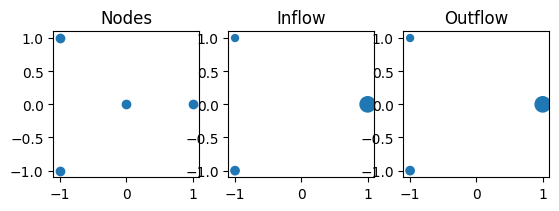

In [6]:
fig, ax = plt.subplots(1, 3)
gdf.plot(ax=ax[0])
ax[0].set_title("Nodes")
gdf.plot(markersize=(gdf["total_inflow"]**2).tolist(), ax=ax[1])
ax[1].set_title("Inflow")
gdf.plot(markersize=(gdf["total_outflow"]**2).tolist(), ax=ax[2])
ax[2].set_title("Outflow")
plt.show()

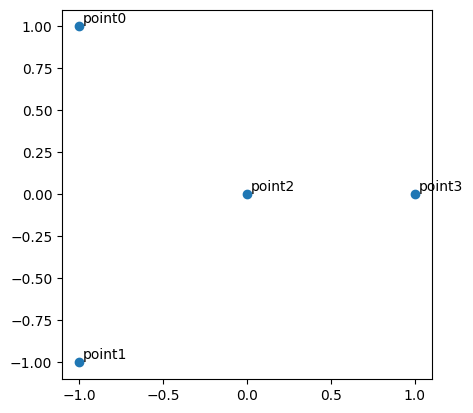

In [7]:
gdf["name"] = gdf.index.tolist()
ax = gdf.plot()

for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf.name):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
    
gdf.drop("name", axis=1, inplace=True)

In [8]:
planes_df = pd.DataFrame(index=["plane1","plane2"])

planes_df["cap"] = [5,10]
planes_df["cost"] = [2, 3]
planes_df["max_dist"] = [1.5, 4]
planes_df["land_cost"] = [5, 5]

#add a zero plane:
zero_plane = pd.DataFrame(index=["noplane"])
zero_plane["cap"] = 0
zero_plane["cost"] = 0
zero_plane["max_dist"] = planes_df["max_dist"].max()
zero_plane["land_cost"] = 0
planes_df = pd.concat([zero_plane, planes_df], ignore_index=False)

planes_df

,cap,cost,max_dist,land_cost
noplane,0,0,4.0,0
plane1,5,2,1.5,5
plane2,10,3,4.0,5


In [9]:
planes = [n for n in planes_df.index.tolist()]
nodes = [i for i in df.index.tolist()]


    
max_dist = planes_df["max_dist"].max()
for node in nodes:
    min_dist = gdf[node].astype(float).nsmallest(2).tolist()[-1]
    if min_dist > max_dist:
        print(node, "is to far away from the system")
        

arcs = [(i,j) for i in nodes for j in nodes if i!=j] #check all arcs
D_ij = {} #length of arc i,j
N_ij = {} #planes available between i and j
poss_arcs = [] #only use possible arcs
for tup in arcs:
    dist_ij = gdf[tup[0]][tup[1]] #length of arc
    n_list = []
    for plane in planes: #check if there are any planes that 
        if planes_df["max_dist"][plane]>dist_ij:
            n_list.append(plane)
    if len(n_list) > 0:
        poss_arcs.append(tup)
        D_ij[tup] = dist_ij
        N_ij[tup] = n_list

all_arcs = arcs
arcs = poss_arcs #only use possible arcs

commodities = [h for h in nodes]
W_h_i = {} #demand of commodity h at node i

for node in nodes:
    com = node
    total_flow_in = df[node].sum()
    W_h_i[(com, node)] = -total_flow_in
    
    for com in nodes:
        if com != node:
            flow_out = df[node][com]
            W_h_i[(com,node)] = flow_out


K_n = {}
C_n = {}
Cl_n = {}
for plane in planes:
    K_n[plane] = planes_df["cap"][plane]
    C_n[plane] = planes_df["cost"][plane]
    Cl_n[plane] = planes_df["land_cost"][plane]


arc_plane_n_ij = [(n,i,j) for (i,j) in arcs for n in N_ij[(i,j)]]

C_n_ij = {}
for (n,i,j) in arc_plane_n_ij:
    C_n_ij[(n,i,j)] = C_n[n]*D_ij[(i,j)]


CN_ij = {} #continous cost
KN_ij = {} #
Cl_N = {}
for arc in arcs:
    if len(N_ij[arc])>0:
        plane = N_ij[arc][-1]
        KN_ij[arc] = K_n[plane]
        P_N = C_n[plane]*D_ij[arc]
        CN_ij[arc] = P_N
        Cl_N[arc] = planes_df["land_cost"][plane]
    else:
        KN_ij[arc] = 0
        CN_ij[arc] = 0
        Cl_N[arc] = 0



M = 0
for node in nodes:
    od = df[node].sum()
    M += od
    
M = np.ceil(M) + 1 #np.ceil(M/planes_df["cap"].max()) + 1  #max(max(KN_ij.values()), M) + 1

M_low = np.ceil(M/planes_df["cap"].max()) + 1  #max(max(KN_ij.values()), M) + 1


In [10]:
#model
try:
    m = gp.Model("airfleet")
    
    ###Variables:
    
    
    # Create variables
    f = m.addVars(commodities, arcs, name="F")
    g = m.addVars(arcs, vtype=GRB.BINARY, name="G") 
    a = m.addVars(arc_plane_n_ij, vtype=GRB.BINARY, name="A")
    ag = m.addVars(arcs, ub=M_low, vtype=GRB.INTEGER, name="AG")
    #u = m.addVars(arcs, name="U")
    #u_help = m.addVars(arcs, lb=-M, name="U_help")
    f_arc = m.addVars(arcs, name = "farc")
    #z_help = m.addVars(arcs, name="z_help") 
    #hub_help = m.addVars(nodes, name="hub_help")
    #hub = m.addVars(nodes, vtype=GRB.BINARY, name="hub")
    
    obj = a.prod(C_n_ij) + ag.prod(CN_ij) + ag.prod(Cl_N) + sum(sum(Cl_n[n]*a[n,i,j] for n in N_ij[(i,j)]) for (i,j) in arcs) 
    
    
    #Objective function (a)
    m.setObjective(obj, GRB.MINIMIZE)

    # Flow-conservation constraints
    m.addConstrs(
        (f.sum(h, '*', i) + W_h_i[h, i] == f.sum(h, i, '*')
         for h in commodities for i in nodes), "node")
    
    #F assign total flow on arc
    m.addConstrs((f_arc[i,j] == f.sum("*", i, j) for (i,j) in arcs), "H")

    
    #G see if we use more than one plane:
    m.addConstrs((g[i,j]*M >= f_arc[i,j] - KN_ij[(i,j)] for (i,j) in arcs), "8a")    # g=1 if flow> max capacity
    m.addConstrs(((1-g[i,j])*M >= KN_ij[(i,j)]- f_arc[i,j] for (i,j) in arcs), "8b") # g=0 if flow < max capacity
    
    #A pick a plane
    m.addConstrs((f_arc[i,j] <= sum(K_n[n]*a[n,i,j] for n in N_ij[(i,j)]) + KN_ij[i,j]*ag[i,j] for (i,j) in arcs), "9b") # ensure flow < capacity of the chosen plane
    m.addConstrs((sum(a[n,i,j] for n in N_ij[(i,j)]) + g[i,j] == 1 for (i,j) in arcs), "9a") # pick ONE plane OR pick ag
    
    
    m.addConstrs(M_low*g[i,j] >= ag[i,j] for (i,j) in arcs) #ensure that if you pick ag, then g = 1 
    m.addConstrs(M_low*(1-g[i,j]) >= -ag[i,j] + 0.0001 for (i,j) in arcs) #else 0
    
    #fly the plane back
    #this will become infeasible when symmetry is not ensured
    m.addConstrs(a[n,i,j] == a[n,j,i] for (n,i,j) in arc_plane_n_ij)
    m.addConstrs(ag[i,j] == ag[j,i] for (i,j) in arcs)
    
    
    
    #U calculate how much flow should be covered by "plane g", i.e. with continous flow (all or nothing)
    #m.addConstrs((u_help[i,j] == f_arc[i,j] - sum(K_n[n]*a[n,i,j] for n in N_ij[(i,j)]) for (i,j) in arcs), "10") 
    #for i,j in arcs:
    #    m.addConstr((u[i,j] == gp.max_(u_help[i,j], constant=0))) # u = 0 if a plane "a" was chosen
                                                                  # u = f_arc if "g" was chosen 

    #HUB 
    # keep track of which arcs are being used
    #m.addConstrs((z_help[i,j] == sum(a[n,i,j] for n in N_ij[(i,j)][1::]) for (i,j) in arcs), "10")  # if a plane besides "noplane" or was chosen
                                                                                                    # this arc is being used
    # compute the total amount of arcs going into and out of each node
    #m.addConstrs((hub_help[i] == z_help.sum(i,"*") + z_help.sum("*",i) for i in nodes), "12a")
    
    # assign hub-status
    #M_nodes = (len(nodes) + 1)*2 # Just a value that will always be higher than hub_help
    #m.addConstrs((hub[i]*M_nodes >= hub_help[i]-2  for i in nodes), "12b")             # if "nodes in and out" > 2, hub=1
    #m.addConstrs(((1-hub[i])*M_nodes >= 2-hub_help[i] + 0.001 for i in nodes), "12c")  # if "nodes in and out" <= 2, hub=0
    
    
    m.optimize()
    #for v in m.getVars():
    #    print('%s %g' % (v.VarName, v.X))
    
    print('Obj: %g' % m.ObjVal)

except gp.GurobiError as e:
    print('Error code ' + str(e.errno) + ': ' + str(e))

except AttributeError:
    print('Encountered an attribute error')

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-01


Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142 rows, 114 columns and 420 nonzeros
Model fingerprint: 0x87de63fb
Variable types: 60 continuous, 54 integer (42 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [7e+00, 1e+01]
  Bounds range     [1e+00, 4e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 114.1465242
Presolve removed 60 rows and 33 columns
Presolve time: 0.03s
Presolved: 82 rows, 81 columns, 291 nonzeros
Variable types: 60 continuous, 21 integer (15 binary)
Found heuristic solution: objective 46.8328157

Root relaxation: objective 2.575805e+01, 26 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   25.75805    0    3   46.83282   25.75805  45.0%     - 

In [11]:
# retrieve hubs
# z_s = np.array(m.getAttr("X", z.values())).reshape((n_nodes,n_nodes))
# z_s = z_s.round(1)

# find value True for each row (representing the corresponding hub)
# gdf["hub"] = np.argmax(z_s, axis=1) == range(n_nodes)

# retrieve flow solution
f_arc_s = m.getAttr("X", f_arc)

# retrieve which legs are flown by which plane
a_s = m.getAttr("X", a)
a_sd = {(o, d): plane for (plane, o, d), v in a_s.items() if v != 0}
g_s = m.getAttr("X", g)
g_sd = {k: "over" for k, v in g_s.items() if v != 0}

# note that the legs are not always doable by the plane, so we need to check that before counting the number of legs by planes
planes_leg = {**a_sd, **g_sd}

In [12]:
i = 0

flow_dic = {}
hub_dic = {}
for node in df.index.tolist():
    flow_dic[node] = 0
    hub_dic[node] = 0

for key, val in m.getAttr("X", f).items():
    com = key[0]
    nod0 = key[1]
    nod1 = key[2]
    if com != nod1:
        flow_dic[nod1] += val
        if val > 1:
            try:
                plane = a_sd[nod0,nod1]
            except:
                plane = planes[-1]
#            if com==nod0:
#                print(key, val)
            if plane == planes[-1]:
                hub_dic[nod1] +=1
pos["fin_flow"] = flow_dic.values()

pos["hub"] = hub_dic.values()
pos["hub"] = pos["hub"] >= 1

In [13]:
hub_dic

{'point0': 0, 'point1': 0, 'point2': 0, 'point3': 0}

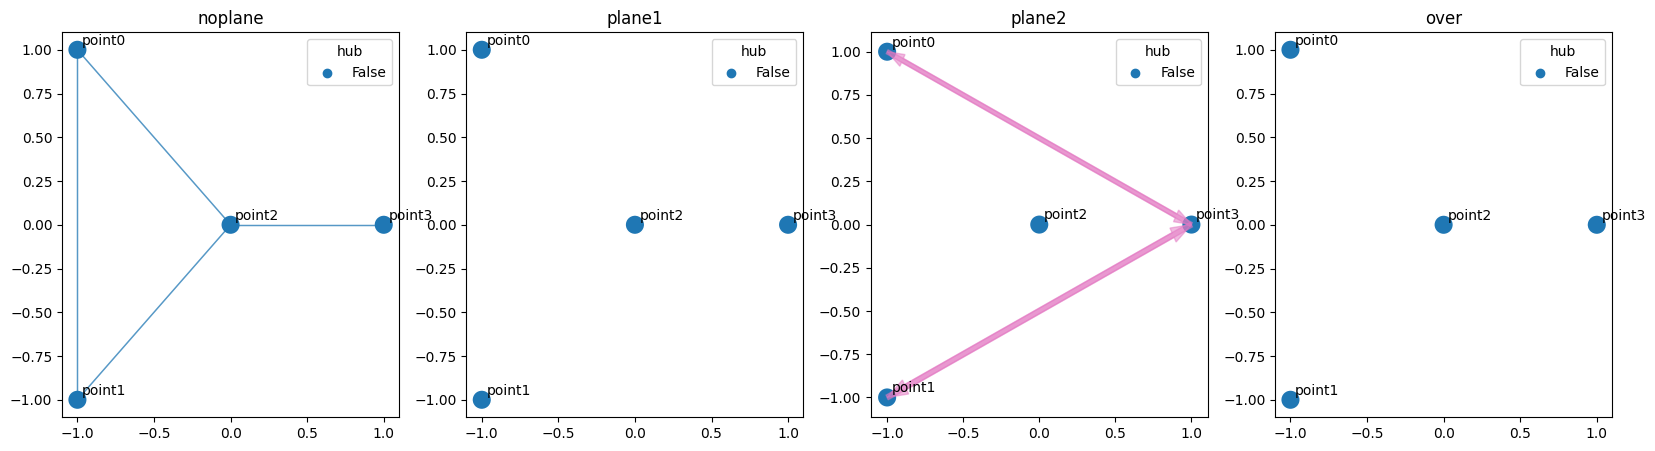

In [14]:
fig, ax = plt.subplots(1, len(planes)+1, figsize=(20,5))

for j, plane in enumerate(planes+["over"]):
    # Plot nodes with edges with the hubs
    sns.scatterplot(x=pos["geometry"].x, y=pos["geometry"].y, s=200, hue=pos['hub'], legend=True, ax=ax[j])
    for i, point in pos.iterrows():
        ax[j].text(point["geometry"].x +.03, point["geometry"].y + 0.03, str(i))
        

    # Now connect the legs with lines
    cmap = plt.get_cmap('tab10')
    colors = cmap(np.linspace(0, 1, len(planes)+1))
    p_to_c = {p:c for p,c in zip(planes + ['over'], colors)}

    for p,q in arcs:
        if planes_leg[p,q] == plane:
            ax[j].arrow(gdf.geometry[p].x, gdf.geometry[p].y, gdf.geometry[q].x - gdf.geometry[p].x, gdf.geometry[q].y - gdf.geometry[p].y, width=f_arc_s[p,q]*0.005, length_includes_head=True, color=p_to_c[planes_leg[p,q]], alpha=0.5)
    ax[j].set_title(plane)

# show colorbar for planes
# cbar = fig.colorbar(mappable=ScalarMappable(cmap=cmap), ticks=np.linspace(0, 1, len(planes)+1))
# cbar.ax.set_yticklabels(planes + ['over']);

In [15]:
df

,point0,point1,point2,point3,geometry
point0,0.0,0.0,0.0,5.0,POINT (-1 1)
point1,0.0,0.0,0.0,6.0,POINT (-1 -1)
point2,0.0,0.0,0.0,0.0,POINT (0 0)
point3,5.0,6.0,0.0,0.0,POINT (1 0)


In [16]:
planes_df

,cap,cost,max_dist,land_cost
noplane,0,0,4.0,0
plane1,5,2,1.5,5
plane2,10,3,4.0,5


In [17]:
C_n_ij

{('noplane', 'point0', 'point1'): 0.0,
 ('plane2', 'point0', 'point1'): 6.0,
 ('noplane', 'point0', 'point2'): 0.0,
 ('plane1', 'point0', 'point2'): 2.8284271247461903,
 ('plane2', 'point0', 'point2'): 4.242640687119286,
 ('noplane', 'point0', 'point3'): 0.0,
 ('plane2', 'point0', 'point3'): 6.708203932499369,
 ('noplane', 'point1', 'point0'): 0.0,
 ('plane2', 'point1', 'point0'): 6.0,
 ('noplane', 'point1', 'point2'): 0.0,
 ('plane1', 'point1', 'point2'): 2.8284271247461903,
 ('plane2', 'point1', 'point2'): 4.242640687119286,
 ('noplane', 'point1', 'point3'): 0.0,
 ('plane2', 'point1', 'point3'): 6.708203932499369,
 ('noplane', 'point2', 'point0'): 0.0,
 ('plane1', 'point2', 'point0'): 2.8284271247461903,
 ('plane2', 'point2', 'point0'): 4.242640687119286,
 ('noplane', 'point2', 'point1'): 0.0,
 ('plane1', 'point2', 'point1'): 2.8284271247461903,
 ('plane2', 'point2', 'point1'): 4.242640687119286,
 ('noplane', 'point2', 'point3'): 0.0,
 ('plane1', 'point2', 'point3'): 2.0,
 ('plane2',

In [18]:
f_arc_s

{('point0', 'point1'): 0.0,
 ('point0', 'point2'): 0.0,
 ('point0', 'point3'): 5.0,
 ('point1', 'point0'): 0.0,
 ('point1', 'point2'): 0.0,
 ('point1', 'point3'): 6.0,
 ('point2', 'point0'): 0.0,
 ('point2', 'point1'): 0.0,
 ('point2', 'point3'): 0.0,
 ('point3', 'point0'): 5.0,
 ('point3', 'point1'): 6.0,
 ('point3', 'point2'): 0.0}

In [19]:
# planes_leg_none = planes_leg.copy()
# for p,q in arcs:
#     if (f_arc_s[p,q] == 0):
#         planes_leg_none[p,q] = None
# {k: (v, planes_leg_none[k[:-1]], planes_leg_none[k[1:]]) for k, v in m.getAttr("X", y).items() if v > 0}

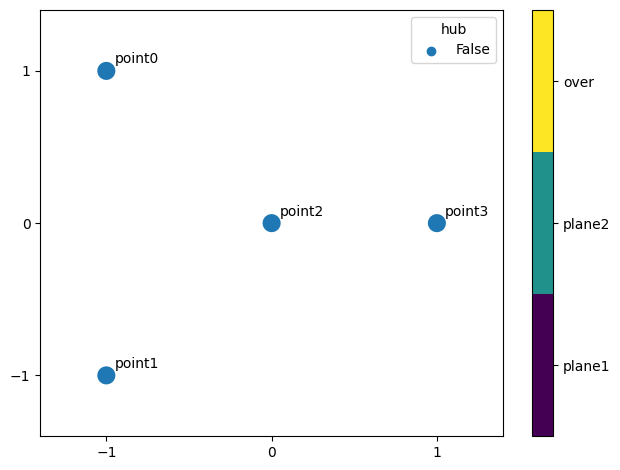

In [24]:
# create figure larger than the default size to make space for the colorbar
# plt.figure(figsize=(11,6))

# Plot nodes with edges with the hubs
sns.scatterplot(data=pos, x=pos["geometry"].x, y=pos["geometry"].y, s=200, hue='hub', legend=True)
for i, point in pos.iterrows():
    plt.text(point["geometry"].x +.05, point["geometry"].y + 0.05, str(i))
    

# Now connect the legs with lines
# make numpy array of colors for each plane
cmap = plt.get_cmap('viridis', len(planes))
colors = cmap(np.linspace(0, 1, len(planes)))
p_to_c = {p:c for p,c in zip(planes[1:] + ['over'], colors)}

for p,q in arcs:
    if f_arc_s[p,q] > 0:
        plt.arrow(pos.geometry[p].x, pos.geometry[p].y, pos.geometry[q].x - pos.geometry[p].x, pos.geometry[q].y - pos.geometry[p].y, width=f_arc_s[p,q]*0.005, length_includes_head=True, color=p_to_c[planes_leg[p,q]], alpha=0)
    
# show colorbar for planes
from matplotlib.cm import ScalarMappable
# plot colormap only in range 0-0.5
cbar = plt.colorbar(mappable=ScalarMappable(cmap=cmap), ticks=np.linspace(1/len(planes)/2, 1 - 1/len(planes)/2, len(planes)))
cbar.ax.set_yticklabels(planes[1:] + ['over'])

# set axis limits
plt.xlim([-1.4, 1.4])
plt.ylim([-1.4, 1.4])
# delete axis ticks
plt.xticks([-1, 0, 1])
plt.yticks([-1, 0, 1]);

plt.tight_layout()

In [21]:
# count the number of legs by plane
legs_by_plane = {plane:0 for plane in planes+["over"]}
for p,q in arcs:
    legs_by_plane[planes_leg[p,q]] += 1 * (f_arc_s[p,q] != 0)
legs_by_plane

{'noplane': 0, 'plane1': 0, 'plane2': 4, 'over': 0}